In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nuclass.data import icecat1_cut
import numpy as np
import pandas as pd
from tqdm import tqdm
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
# window for source analysis, in days, relative to a reference time 
phase_min = 0.
phase_max = +180.

# Set up IceCube data

In [3]:
# Set Up Times
t_min = icecat1_cut["EVENTMJD"].min()
t_length = icecat1_cut["EVENTMJD"].max() - t_min

We need to convert the IceCube coordinates, which has a center and +/- bounds, to exact corners of a rectangle

In [4]:
def calculate_recatangle_bounds(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the bounds of a rectangle for a neutrino.

    This is a bit non-trivial, because you need to wrap around the 0/2 pi boundary
    """
    df = df.copy()

    # Calculate bounds of rectangle for each neutrino

    # RA lower bound
    ra_min = df["RARAD"] - np.radians(df["RA_ERR_MINUS"])
    # Wrap around 2 pi
    ra_min[ra_min < 0.] += 2 * np.pi
    df["RAMIN"] = ra_min
    
    # Ra upper bound
    ra_max = df["RARAD"] + np.radians(icecat1_cut["RA_ERR_PLUS"])
    # Wrap around 2 pi
    ra_max[ra_max > 2 * np.pi] -= 2 * np.pi
    df["RAMAX"] = ra_max

    # Dec bounds (here it's fine maths-wise to have bounds beyond +90 or -90)
    df["DECMIN"] = df["DECRAD"] - np.radians(df["DEC_ERR_MINUS"])
    df["DECMAX"] = df["DECRAD"] + np.radians(df["DEC_ERR_PLUS"])
    return df

In [5]:
icecat1_cut["RARAD"] = np.radians(icecat1_cut["RA"])
icecat1_cut["DECRAD"] = np.radians(icecat1_cut["DEC"])
icecat1_cut = calculate_recatangle_bounds(icecat1_cut)

In [6]:
def scramble_positions(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function randomly redistributes the neutrino alerts in RA and time, 
    producing a simulated neutrino catalogue
    """
    new_df = df.copy()
    
    # Scramble 
    # Uniform in RA
    new_ra  = np.random.uniform(size=len(df)) * 2 * np.pi
    # Uniform in time
    new_times = t_min + np.random.uniform(size=len(df)) * t_length

    new_df["RARAD"] = new_ra
    new_df["DECRAD"] = np.radians(df["DEC"]) # Keep dec the same
    new_df["EVENTMJD"] = new_times

    new_df = calculate_recatangle_bounds(new_df)
    return new_df

In [7]:
# Let's try scrambling the catalogue
df = scramble_positions(icecat1_cut)

In [8]:
# Here we see that all the events have new RA values and new times
df

,Unnamed: 0,NAME,RUNID,EVENTID,START,EVENTMJD,I3TYPE,RA,DEC,RA_ERR_PLUS,...,THRGOING_SCR,CR_VETO,OTHER_I3TYPES,AREA,RARAD,DECRAD,RAMIN,RAMAX,DECMIN,DECMAX
0,0,IC110514A,118178,17334444,2011-05-14 01:32:22.654109,58988.956198,gfu-gold,138.47,-1.94,6.68,...,0.919000,False,NaN,21.848835,0.630122,-0.033859,0.564148,0.746710,-0.053407,-0.016930
1,1,IC110610A,118309,46569873,2011-06-10 10:13:33.147086,59956.410337,gfu-gold,272.55,35.64,1.67,...,1.000000,False,gfu-bronze,7.810647,2.523671,0.622035,2.481434,2.552818,0.603709,0.644725
2,3,IC110714A,118435,58198553,2011-07-14 02:42:41.855488,56237.186200,hese-gold,68.20,40.67,0.31,...,0.124000,False,hese-bronze,0.941107,0.183770,0.709825,0.164572,0.189181,0.702146,0.717505
3,7,IC110902A,118631,36844560,2011-09-02 02:12:46.331046,58892.009291,gfu-gold,9.76,7.59,2.86,...,0.999000,False,gfu-bronze,7.168015,0.984032,0.132470,0.960994,1.033949,0.117461,0.147655
4,8,IC110907A,118660,61529737,2011-09-07 19:04:14.783520,57866.560717,gfu-gold,196.08,9.40,3.91,...,0.000146,False,gfu-bronze,16.968693,1.768449,0.164061,1.721674,1.836691,0.145560,0.191114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,331,IC230306A,137711,79205800,2023-03-06 10:59:30.413953,58355.919647,gfu-gold,72.86,34.23,0.79,...,1.000000,False,gfu-bronze,2.250569,5.295466,0.597426,5.280107,5.309254,0.583115,0.611563
93,339,IC230707A,138125,11333473,2023-07-07 16:58:50.035539,57545.637484,gfu-gold,269.03,-1.94,0.88,...,0.000250,False,"ehe-gold,gfu-bronze,hese-bronze",1.642258,0.509693,-0.033859,0.497476,0.525052,-0.042935,-0.024784
94,342,IC230724A,138181,66037171,2023-07-24 01:49:13.38,59633.562641,gfu-gold,32.52,-1.87,0.58,...,0.993000,False,gfu-bronze,0.548508,5.958190,-0.032638,5.951209,5.968313,-0.038397,-0.028623
95,345,IC230914A,138354,45413430,2023-09-14 05:21:03.717216,59803.314025,gfu-bronze,163.83,31.83,2.55,...,1.000000,False,NaN,14.947478,2.311965,0.555538,2.276710,2.356471,0.524646,0.591841


In [9]:
# This is a completely randomised catalogue of 100 sources, distributed across the sky
n = 100

cat = pd.DataFrame()
cat["RARAD"] = np.random.uniform(size=n) * 2 * np.pi
cat["DECRAD"] = -np.pi/2. + np.random.uniform(size=n) * np.pi
cat["REFMJD"] = t_min + np.random.uniform(size=n) * t_length
cat

,RARAD,DECRAD,REFMJD
0,1.636078,-1.257658,59257.472440
1,0.952677,-0.091627,56770.066686
2,1.429411,-0.479124,59642.782529
3,2.266706,0.009010,56434.897854
4,1.923275,0.709870,56775.598731
...,...,...,...
95,5.440127,-0.048257,58049.086124
96,4.351728,-0.569159,59483.356564
97,5.077060,1.430897,56242.075169
98,5.723994,0.528745,57712.436091


In [10]:
# Goal - replace with a real catalogue from TNS

# First download 

# # Read in csv from TNS
cat = pd.concat([pd.read_csv("/Users/robertstein/Downloads/tns_search.csv"), pd.read_csv("/Users/robertstein/Downloads/tns_search(1).csv")])

# Convert coordinates to radians
t = SkyCoord(cat["RA"], cat["DEC"], unit=(u.hourangle, u.deg))
cat["RARAD"] = t.ra.radian
cat["DECRAD"] = t.dec.radian

# Convert iso times to mjd
cat["REFMJD"] = [Time(x.replace(" ", "T"), format="isot", scale="utc").mjd for x in cat["Discovery Date (UT)"]]
cat

,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,...,Discovery Filter,Discovery Date (UT),Sender,Remarks,Discovery Bibcode,Classification Bibcodes,Ext. catalog/s,RARAD,DECRAD,REFMJD
0,158030,AT 2024qab,18:14:06.192,+36:14:59.69,TDE,0.139800,NaN,NaN,"ZTF, ATLAS, GOTO","ZTF, ATLAS, GOTO",...,g-ZTF,2024-06-15 09:00:16.001,Fritz,NaN,2024TNSTR2568....1S,2024TNSCR2633....1C,NaN,4.773926,0.632680,60476.375185
1,157893,AT 2024pvu,23:31:11.947,+22:15:31.71,TDE,0.048000,NaN,NaN,"ZTF, GOTO","ZTF, GOTO",...,g-ZTF,2024-07-10 10:41:47.996,Fritz,NaN,2024TNSTR2534....1B,2024TNSCR2947....1S,NaN,6.157518,0.388489,60501.445694
2,153618,AT 2024lhc,16:50:54.181,+32:52:36.21,TDE,0.204500,NaN,NaN,"ZTF, Pan-STARRS, ATLAS, GOTO","ZTF, Pan-STARRS, ATLAS, GOTO",...,g-ZTF,2024-05-01 08:47:56.996,Fritz,NaN,2024TNSTR1958....1R,2024TNSCR2237....1C,NaN,4.410897,0.573807,60431.366632
3,150136,AT 2024gxr,17:22:32.637,+18:13:58.20,TDE-He,0.051000,NaN,NaN,ZTF,ZTF,...,r-ZTF,2024-04-17 09:07:25.003,Fritz,NaN,2024TNSTR1150....1S,"2024TNSCR1637....1F, 2024TNSCR1840....1S",NaN,4.548956,0.318223,60417.380150
4,149950,AT 2024gre,10:31:38.891,+34:54:30.00,TDE,0.120000,SDSS J103138.88+345430.0,NaN,"ALeRCE, ATLAS, Pan-STARRS","ZTF, ATLAS, Pan-STARRS",...,g-ZTF,2024-04-12 07:41:42.000,ALeRCE,NaN,2024TNSTR1079....1M,2024TNSCR1840....1S,NaN,2.756085,0.609265,60412.320625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,29459,AT 2018fyk,22:50:16.090,-44:51:53.50,TDE,0.060000,LCRS B224721.6-450748,NaN,"ASAS-SN, GaiaAlerts","ASAS-SN, GaiaAlerts",...,g-Sloan,2018-09-08 05:31:12.000,Stanek,NaN,2018TNSTR1325....1S,2018TNSCR1397....1W,NaN,5.978923,-0.783040,58369.230000
38,28094,AT 2018dyb,16:10:58.774,-60:55:23.16,TDE,0.018000,WKK 6047,0.017932,ASAS-SN,ASAS-SN,...,V-Johnson,2018-07-11 05:31:12.000,Stanek,NaN,2018TNSTR.982....1B,2018TNSCR.998....1P,NaN,4.236698,-1.063309,58310.230000
39,26571,AT 2018bsi,08:15:26.621,+45:35:31.95,TDE,0.051000,NaN,NaN,ZTF,ZTF,...,r-ZTF,2018-04-09 05:05:16.000,ZTF_Bot1,NaN,2018TNSTR.652....1F,2020TNSCR2260....1D,NaN,2.161781,0.795734,58217.211991
40,25321,AT 2018zr,07:56:54.537,+34:15:43.61,TDE,0.071000,NaN,NaN,"Pan-STARRS, ATLAS","Pan-STARRS, ATLAS",...,i-Sloan,2018-03-02 07:48:00.000,PS1_Bot1,NaN,2018TNSTR.296....1C,2020TNSCR2246....1D,NaN,2.080908,0.597987,58179.325000


In [11]:
def check_matches_single(nu: pd.DataFrame, src: pd.DataFrame) -> int:
    """
    Check how many (if any) sources are coincident with a neutrino

    :param nu: pd.Series entry for neutrino, from IceCat
    :param src: Source Catalogue

    :return: Number of matches for one neutrino
    """
    # Check wrap if rectangle overlaps 360 wraparound 
    if nu["RAMAX"] < nu["RAMIN"]:
        # Check if sources lie in the lower or upper RA range
        ra_mask = (
            (src["RARAD"] < nu["RAMAX"]) | (src["RARAD"] > nu["RAMIN"])
        )

    else:
        # Check if source lies in the ra range
        ra_mask = src["RARAD"].between(nu["RAMIN"], nu["RAMAX"])

    # Check if source lies in dec range
    dec_mask = src["DECRAD"].between(nu["DECMIN"], nu["DECMAX"])

    # Check if neutrino is temporally coincident with source
    time_mask = (nu["EVENTMJD"] - src["REFMJD"]).between(phase_min, phase_max)

    # Check if spatially AND temporally coincident
    mask = ra_mask & dec_mask & time_mask
    return int(mask.sum())

def check_matches(src: pd.DataFrame, nudf: pd.DataFrame) -> int:
    """
    Iteratively the total number of neutrino-source matches

    :param src: Source catalogue
    :param nudf: Dataframe containing all neutrino positions
    
    :return: Total number of neutrino-source matches
    """
    n_match = 0
    for i, nu in nudf.iterrows():
        n_match += check_matches_single(nu, src)
    return n_match

In [12]:
true_matches = check_matches(cat, icecat1_cut)
print(f"Found {true_matches} neutrino-catalogue matches")
true_matches

Found 1 neutrino-catalogue matches


1

In [13]:
# Calculate background matches
trials = []

In [14]:
# Run many randomised experiments to compare
n_trial = 1000

for i in tqdm(range(n_trial)):
    df = scramble_positions(icecat1_cut)
    trial_matches = check_matches(cat, df)
    trials.append(trial_matches)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.07it/s]


(0.0, 1.0)

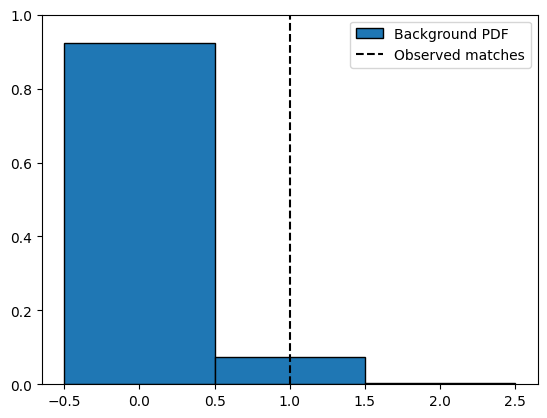

In [15]:
# Plot the distrubtion of random matches expected, alongside the true result 
data = pd.Series(trials)
left_of_first_bin = data.min() - 0.5
right_of_last_bin = data.max() + 0.5

weight = np.ones(len(data))/len(data)

plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + 1, 1), weights=weight, edgecolor='black', label="Background PDF")
plt.axvline(true_matches, label="Observed matches", color="k", linestyle="--")
plt.legend()
plt.ylim(top=1.0)

In [16]:
trial_series = pd.Series(trials)
n_less = (trial_series < true_matches).sum()
n_tot = len(trial_series)
frac = n_less/n_tot

print(f"{n_less} of the {n_tot} trials yielded fewer matches than the real data ({true_matches} matches)")
print(f"This corresponds to {100.*frac:.2f}%, and means an excess above background expectations {['has', 'has not'][int(frac < 0.5)]} been observed")

924 of the 1000 trials yielded fewer matches than the real data (1 matches)
This corresponds to 92.40%, and means an excess above background expectations has been observed
